In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x) #prevent scientific number display
%matplotlib inline

# Import Data

In [2]:
dataset = pd.read_excel('Dataset.xlsx', sheet_name = 'Data Set')
market = pd.read_excel('Dataset.xlsx', sheet_name = 'Market')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Market ID          720 non-null    int64
 1   Year               720 non-null    int64
 2   Month              720 non-null    int64
 3   Rent               720 non-null    int64
 4   Fees               720 non-null    int64
 5   Starting Units     720 non-null    int64
 6   New Units          720 non-null    int64
 7   Lost Units         720 non-null    int64
 8   Total Nights Sold  720 non-null    int64
dtypes: int64(9)
memory usage: 50.8 KB


In [4]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Market    20 non-null     object
 1   MarketId  20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 448.0+ bytes


# Data Processing

In [5]:
# join the datasets (dataset & market)

col_drop = ['MarketId','Market ID']

org_data_set = dataset.merge(market, how = 'left', left_on = 'Market ID',
            right_on = 'MarketId' ).drop(columns = col_drop )

org_data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 0 to 719
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Year               720 non-null    int64 
 1   Month              720 non-null    int64 
 2   Rent               720 non-null    int64 
 3   Fees               720 non-null    int64 
 4   Starting Units     720 non-null    int64 
 5   New Units          720 non-null    int64 
 6   Lost Units         720 non-null    int64 
 7   Total Nights Sold  720 non-null    int64 
 8   Market             720 non-null    object
dtypes: int64(8), object(1)
memory usage: 56.2+ KB


## By Market Transformantion

In [6]:
# Create date index and order columns

from pandas.tseries.offsets import MonthEnd

org_data_set['YearMonth'] = org_data_set['Year'].astype(str)+org_data_set['Month'].astype(str)

org_data_set['Date']= pd.to_datetime(org_data_set['YearMonth'], format="%Y%m") + MonthEnd(1)

col_drop1 = ['Year','YearMonth']
#col_drop1 = ['Year','Month', 'YearMonth'] 

column_order = ['Date','Month', 'Market','Rent','Fees','Total Nights Sold',
               'Starting Units','New Units','Lost Units']

org_data_set = org_data_set.drop(columns = col_drop1).reindex(columns = column_order).set_index(['Market','Date']).sort_index()

In [7]:
org_data_set.head(5)

Month    Rent    Fees  Total Nights Sold  \
Market           Date                                                   
AL - Gulf Shores 2019-01-31      1  106045   29585               1798   
                 2019-02-28      2  182407   46042               2895   
                 2019-03-31      3  481689  134379               3775   
                 2019-04-30      4  428712  154131               3051   
                 2019-05-31      5  624254  204287               3470   

                             Starting Units  New Units  Lost Units  
Market           Date                                               
AL - Gulf Shores 2019-01-31             172          4           7  
                 2019-02-28             168          5           8  
                 2019-03-31             169          4           1  
                 2019-04-30             171         12           1  
                 2019-05-31             182          7           2

In [8]:
# Set up data to calculate outlier months in 2020 (COVID) at Market level.
pd.options.mode.chained_assignment = None  # default='warn'

#Update as needed:
#----------------------------------------------------------------|
market = 'FL - Panama City Beach'
time_range_comparable = slice('2021-03-31','2021-06-30')# needs an additional month
time_covid_start = '2020-03-31'
time_covid_period = slice('2020-03-31','2020-05-31')
col_drop2 = ['Market','Date','Starting Units','New Units','Lost Units']
col_drop3 = ['Rent','Fees','Total Nights Sold']

#Gets the data needed for the calculation comparable and covid period
comparable_period = org_data_set.loc[(market,time_range_comparable),:].reset_index().drop(columns = col_drop2 )
time_covid_start = org_data_set.loc[(market,time_covid_start),:].reset_index().drop(columns = col_drop2 )
unchanged_cols_covid_2020 = org_data_set.loc[(market,time_covid_period),:].reset_index().drop(columns = col_drop3 )
#----------------------------------------------------------------|

#Update as needed:
#---------------------------------------------------------------|
col1 = 'Rent'
col2 = 'Fees'
col3 = 'Total Nights Sold'
delta_col1_name = 'Rent_delta'
delta_col2_name = 'Fees_delta'
delta_col3_name = 'Total Nights Sold_delta'

#Creates the % change from month to month
comparable_period[delta_col1_name] = comparable_period[col1].pct_change(periods = 1)
comparable_period[delta_col2_name] = comparable_period[col2].pct_change(periods = 1)
comparable_period[delta_col3_name] = comparable_period[col3].pct_change(periods = 1)
comparable_period = comparable_period.drop(columns = col_drop3).dropna()
#---------------------------------------------------------------|

#Creates date column for covid period
covid_dates = unchanged_cols_covid_2020.iloc[:,1]

In [15]:
# Recalculation of  outlier columns in months of 2020 (COVID)
#----------------------------------------------------------------|
#Update as needed:
col = 'Fees'
col_delta = col+'_delta'

#adds values to be transforms into lists
attribute = list()
attribute = [x for x in time_covid_start[col]]
pct_change = list()
pct_change = [x for x in comparable_period[col_delta]]
covid_dates = [x for x in covid_dates]
covid_outlier_ouput = dict()
    
for i in range(len(pct_change)):
    if i == 0: attribute.append(attribute[0]*(1+pct_change[0]))  
    else: attribute.append(attribute[i]*(1+pct_change[i]))
print('Recalculated'+' '+col+':',attribute[1:])
        
for i in range(len(attribute)-1):
    covid_outlier_ouput[covid_dates[i]] = attribute[i+1]
#----------------------------------------------------------------|
    
#----------------------------------------------------------------|
#Update as needed:
column_order1 = ['Month','Rent','Fees','Total Nights Sold',
               'Starting Units','New Units','Lost Units']

unchanged_cols_covid_2020[col] = unchanged_cols_covid_2020.Date.map(covid_outlier_ouput)

updated_cols_covid_2020 = unchanged_cols_covid_2020.set_index(['Date'],
                                drop = True).drop(columns = 'Market').reindex(columns = column_order1)
updated_cols_covid_2020
#----------------------------------------------------------------|

Recalculated Fees: [584059.5656053672, 726893.9156209504, 922710.8314660805]


,Month,Rent,Fees,Total Nights Sold,Starting Units,New Units,Lost Units
Date,,,,,,,
2020-03-31,3,1628475.04285,584059.56561,15524.99674,1344,28,24
2020-04-30,4,2162088.09484,726893.91562,18290.06515,1347,5,33
2020-05-31,5,3732442.31462,922710.83147,19648.67622,1321,17,29


In [16]:
#Get data by columns without outlier and appends updated outlier data.

market_df = org_data_set.loc[market].drop( index = covid_dates)
market_df = market_df.append(updated_cols_covid_2020).sort_index()

<AxesSubplot:xlabel='Date'>

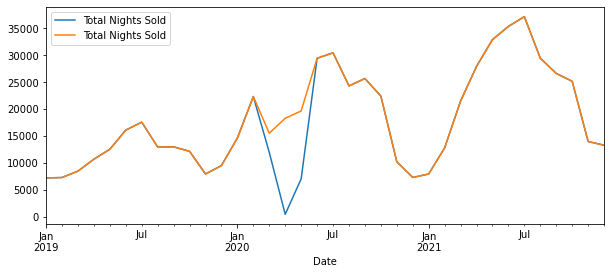

In [17]:
org_data_set.loc['FL - Panama City Beach','Total Nights Sold'].plot.line( figsize = (10,4), legend = True )
market_df['Total Nights Sold'].plot.line( figsize = (10,4), legend = True )

In [18]:
#caluculate inventory
market_df['inventory'] = (market_df['Starting Units']+market_df['New Units'])-market_df['Lost Units']

#adds period col
market_df['Period'] = np.arange(len(market_df))

#Dummy Variables
market_df = pd.get_dummies(market_df, columns = ['Month'], drop_first = True)

In [19]:
market_df.head()

,Rent,Fees,Total Nights Sold,Starting Units,New Units,Lost Units,inventory,Period,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,,,,,,,
2019-01-31,492637.00000,126191.00000,7234.00000,430,12,16,426,0,0,0,0,0,0,0,0,0,0,0,0
2019-02-28,546487.00000,122916.00000,7307.00000,431,11,5,437,1,1,0,0,0,0,0,0,0,0,0,0
2019-03-31,1126778.00000,328407.00000,8498.00000,439,340,9,770,2,0,1,0,0,0,0,0,0,0,0,0
2019-04-30,1641105.00000,548256.00000,10706.00000,770,20,3,787,3,0,0,1,0,0,0,0,0,0,0,0
2019-05-31,2122574.00000,717113.00000,12547.00000,767,21,24,764,4,0,0,0,1,0,0,0,0,0,0,0
